In [43]:
# Imports
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection
from tempfile import TemporaryDirectory

import time
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18
import numpy as np
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
RNG = torch.Generator().manual_seed(42)

Running on device: CUDA


Step 1 - Loading dataset

In [44]:
# CIFAR 10 dataset

# Transformations
normalize = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

# Train data
train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=normalize
)
# Train loader
train_loader = DataLoader(train_set, batch_size=256, shuffle=True, num_workers=2)

# Test data
test_set = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=normalize
)
# Test loader
test_loader = DataLoader(test_set, batch_size=256, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Step 2 - split train set on forget / retain

In [45]:
# Show different classes
classes = np.unique(np.array(train_set.targets))
classes

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [46]:
# Choose random forget indecies from some class
# Index of class
class_index = 1 # cars
class_set = np.where(np.array(train_set.targets) == 1)[0]

# Percantage of whole data ( from class )
amount = 0.01 # 1 %
amount_int = class_set.shape[0] * amount

# Get indeces
forget_idx = np.random.choice(class_set, int(amount_int))

# construct indices of retain from those of the forget set
forget_mask = np.zeros(len(train_set.targets), dtype=bool)
forget_mask[forget_idx] = True
retain_idx = np.arange(forget_mask.size)[~forget_mask]

# split train set into a forget and a retain set
forget_set = torch.utils.data.Subset(train_set, forget_idx)
retain_set = torch.utils.data.Subset(train_set, retain_idx)

# Generate forget and retain loaders
forget_loader = torch.utils.data.DataLoader(
    forget_set, batch_size=256, shuffle=True, num_workers=2, generator=RNG
)
retain_loader = torch.utils.data.DataLoader(
    retain_set, batch_size=256, shuffle=True, num_workers=2, generator=RNG
)

In [6]:
# Add helping dicts


dataloaders = {
    "train": train_loader,
    "val": test_loader
}

dataset_sizes = {"train": len(train_set), "val": len(test_set)}

Step 3 - Choose and train model

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(DEVICE)
                    labels = labels.to(DEVICE)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [11]:
# Train ResNet18

model_train = resnet18(weights=None, num_classes=10) # Load resnet18 from pytorch
model_train = model_train.to(DEVICE)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_train.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [12]:
# Train model
model_train = train_model(model_train, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------
train Loss: 1.3809 Acc: 0.5029
val Loss: 1.2731 Acc: 0.5502

Epoch 1/14
----------
train Loss: 0.9771 Acc: 0.6524
val Loss: 1.0384 Acc: 0.6399

Epoch 2/14
----------
train Loss: 0.7935 Acc: 0.7213
val Loss: 0.9393 Acc: 0.6786

Epoch 3/14
----------
train Loss: 0.6567 Acc: 0.7706
val Loss: 0.9556 Acc: 0.6795

Epoch 4/14
----------
train Loss: 0.5483 Acc: 0.8078
val Loss: 0.8511 Acc: 0.7234

Epoch 5/14
----------
train Loss: 0.4587 Acc: 0.8406
val Loss: 0.8680 Acc: 0.7216

Epoch 6/14
----------
train Loss: 0.3752 Acc: 0.8686
val Loss: 0.8952 Acc: 0.7287

Epoch 7/14
----------
train Loss: 0.1536 Acc: 0.9524
val Loss: 0.7961 Acc: 0.7686

Epoch 8/14
----------
train Loss: 0.0803 Acc: 0.9788
val Loss: 0.8647 Acc: 0.7664

Epoch 9/14
----------
train Loss: 0.0463 Acc: 0.9901
val Loss: 0.9624 Acc: 0.7660

Epoch 10/14
----------
train Loss: 0.0270 Acc: 0.9950
val Loss: 1.0593 Acc: 0.7621

Epoch 11/14
----------
train Loss: 0.0144 Acc: 0.9980
val Loss: 1.1752 Acc: 0.7626

Ep

In [13]:
# Save model weights
torch.save(model_train.state_dict(), "model_train_params.pt")

Step 4 - Check accuracy on trained model

In [15]:
def accuracy(net, loader):
    """Return accuracy on a dataset given by the data loader."""
    correct = 0
    total = 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return correct / total


print(f"Train set accuracy: {100.0 * accuracy(model_train, train_loader):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(model_train, test_loader):0.1f}%")

Train set accuracy: 98.2%
Test set accuracy: 76.9%


Step 5 - Apply forget mechanism

In [18]:

def unlearning(net, retain, forget, validation):
    """Unlearning by fine-tuning.

    Fine-tuning is a very simple algorithm that trains using only
    the retain set.

    Args:
      net : nn.Module.
        pre-trained model to use as base of unlearning.
      retain : torch.utils.data.DataLoader.
        Dataset loader for access to the retain set. This is the subset
        of the training set that we don't want to forget.
      forget : torch.utils.data.DataLoader.
        Dataset loader for access to the forget set. This is the subset
        of the training set that we want to forget. This method doesn't
        make use of the forget set.
      validation : torch.utils.data.DataLoader.
        Dataset loader for access to the validation set. This method doesn't
        make use of the validation set.
    Returns:
      net : updated model
    """
    epochs = 5

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    net.train()

    for _ in range(epochs):
        for inputs, targets in retain:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        scheduler.step()

    net.eval()
    return net

In [16]:
# Define model from trained params

model_forget_ft = resnet18(weights=None, num_classes=10) # Load resnet18 from pytorch
model_forget_ft.load_state_dict(torch.load("model_train_params.pt"))
model_forget_ft.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
# Unlearn model
%%time
model_ft_forget = unlearning(model_forget_ft, retain_loader, forget_loader, test_loader)

CPU times: user 39.1 s, sys: 2.1 s, total: 41.2 s
Wall time: 1min 23s


In [20]:
# Compare accuracy
print(f"Retain set accuracy: {100.0 * accuracy(model_ft_forget, retain_loader):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(model_ft_forget, test_loader):0.1f}%")


Retain set accuracy: 99.8%
Test set accuracy: 77.0%


Step 5 - Compare loss graphs

In [22]:
def compute_losses(net, loader):
    """Auxiliary function to compute per-sample losses"""

    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = []

    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        logits = net(inputs)
        losses = criterion(logits, targets).numpy(force=True)
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)


train_losses = compute_losses(model_train, train_loader)
test_losses = compute_losses(model_train, test_loader)

In [24]:

def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    """Computes cross-validation score of a membership inference attack.

    Args:
      sample_loss : array_like of shape (n,).
        objective function evaluated on n samples.
      members : array_like of shape (n,),
        whether a sample was used for training.
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      scores : array_like of size (n_splits,)
    """

    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy"
    )


In [25]:
# TRAIN MODEL
# Get random test samples
randomize = np.arange(len(test_losses))
np.random.shuffle(randomize)

# Compute forget losses on train dataset
forget_losses = compute_losses(model_train, forget_loader)

# Since we have more forget losses than test losses, sub-sample them, to have a class-balanced dataset.
test_losses = test_losses[randomize][: len(forget_losses)]

samples_mia = np.concatenate((test_losses, forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(test_losses) + [1] * len(forget_losses)

mia_scores = simple_mia(samples_mia, labels_mia)

print(
    f"The MIA has an accuracy of {mia_scores.mean():.3f} on forgotten vs unseen images"
)


The MIA has an accuracy of 0.780 on forgotten vs unseen images


In [27]:
# FORGET MODEL

# Compute forget losses for forget model
forget_losses_fr = compute_losses(model_ft_forget, forget_loader)
test_losses_fr = compute_losses(model_ft_forget, test_loader)

# Since we have more forget losses than test losses, sub-sample them, to have a class-balanced dataset.
test_losses_fr = test_losses_fr[randomize][: len(forget_losses)]

# make sure we have a balanced dataset for the MIA
samples_mia_fr = np.concatenate((test_losses_fr, forget_losses_fr)).reshape((-1, 1))
labels_mia_fr = [0] * len(test_losses_fr) + [1] * len(forget_losses_fr)

mia_scores_fr = simple_mia(samples_mia_fr, labels_mia_fr)

print(
    f"The MIA has an accuracy of {mia_scores_fr.mean():.3f} on forgotten vs unseen images"
)

The MIA has an accuracy of 0.530 on forgotten vs unseen images


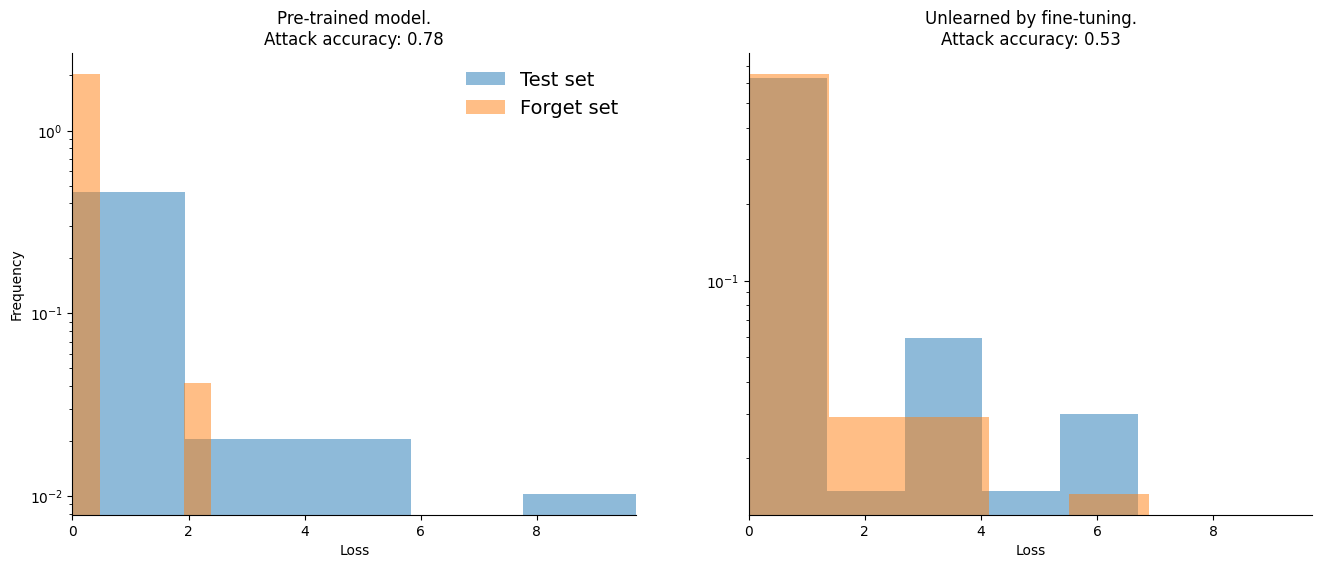

In [33]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title(f"Pre-trained model.\nAttack accuracy: {mia_scores.mean():0.2f}")
ax1.hist(test_losses, density=True, alpha=0.5, bins=5, label="Test set")
ax1.hist(forget_losses, density=True, alpha=0.5, bins=5, label="Forget set")

ax2.set_title(
    f"Unlearned by fine-tuning.\nAttack accuracy: {mia_scores_fr.mean():0.2f}"
)
ax2.hist(test_losses_fr, density=True, alpha=0.5, bins=5, label="Test set")
ax2.hist(forget_losses_fr, density=True, alpha=0.5, bins=5, label="Forget set")

ax1.set_xlabel("Loss")
ax2.set_xlabel("Loss")
ax1.set_ylabel("Frequency")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_xlim((0, np.max(test_losses)))
ax2.set_xlim((0, np.max(test_losses)))
for ax in (ax1, ax2):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
ax1.legend(frameon=False, fontsize=14)
plt.show()

Step 6 - Retrained model only on retain dataset

In [34]:
# Train ResNet18

model_retain_ds = resnet18(weights=None, num_classes=10) # Load resnet18 from pytorch
model_retain_ds = model_retain_ds.to(DEVICE)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_retain_ds.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [36]:
# Add helping dicts


dataloaders = {
    "train": retain_loader,
    "val": test_loader
}

dataset_sizes = {"train": len(retain_set), "val": len(test_set)}

# Train model
model_retain_ds = train_model(model_retain_ds, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------
train Loss: 1.3746 Acc: 0.5051
val Loss: 1.2275 Acc: 0.5639

Epoch 1/14
----------
train Loss: 0.9891 Acc: 0.6487
val Loss: 0.9950 Acc: 0.6563

Epoch 2/14
----------
train Loss: 0.8018 Acc: 0.7188
val Loss: 0.9206 Acc: 0.6832

Epoch 3/14
----------
train Loss: 0.6667 Acc: 0.7646
val Loss: 0.8603 Acc: 0.7072

Epoch 4/14
----------
train Loss: 0.5599 Acc: 0.8021
val Loss: 0.9153 Acc: 0.6949

Epoch 5/14
----------
train Loss: 0.4718 Acc: 0.8341
val Loss: 1.0103 Acc: 0.6846

Epoch 6/14
----------
train Loss: 0.3800 Acc: 0.8670
val Loss: 0.9287 Acc: 0.7239

Epoch 7/14
----------
train Loss: 0.1611 Acc: 0.9507
val Loss: 0.7741 Acc: 0.7740

Epoch 8/14
----------
train Loss: 0.0880 Acc: 0.9761
val Loss: 0.8341 Acc: 0.7721

Epoch 9/14
----------
train Loss: 0.0529 Acc: 0.9876
val Loss: 0.9246 Acc: 0.7700

Epoch 10/14
----------
train Loss: 0.0290 Acc: 0.9938
val Loss: 1.0551 Acc: 0.7677

Epoch 11/14
----------
train Loss: 0.0157 Acc: 0.9975
val Loss: 1.2036 Acc: 0.7644

Ep

In [37]:
# MIA attack on retain model

# Compute forget losses for forget model
forget_losses_rt = compute_losses(model_retain_ds, forget_loader)
test_losses_rt = compute_losses(model_retain_ds, test_loader)

# Since we have more forget losses than test losses, sub-sample them, to have a class-balanced dataset.
test_losses_rt = test_losses_rt[randomize][: len(forget_losses)]

# make sure we have a balanced dataset for the MIA
samples_mia_rt = np.concatenate((test_losses_rt, forget_losses_rt)).reshape((-1, 1))
labels_mia_rt = [0] * len(test_losses_rt) + [1] * len(forget_losses_rt)

mia_scores_rt = simple_mia(samples_mia_rt, labels_mia_rt)

print(
    f"The MIA has an accuracy of {mia_scores_fr.mean():.3f} on forgotten vs unseen images"
)

The MIA has an accuracy of 0.530 on forgotten vs unseen images


Calculate AD statistic

In [39]:
AD = np.linalg.norm(forget_losses_fr-forget_losses_rt)

In [40]:
AD

10.8024845

Step 7 - Gradient map visualisation

In [48]:
# Generalisation
# Calculating score across 10 different classes

# Show different classes
classes = np.unique(np.array(train_set.targets))

MIA_scores = []
Accuracy_retain = []
Accuracy_forget = []
AD_score = []

for class_num in classes:
  # Define model from trained params

  model_forget_ft = resnet18(weights=None, num_classes=10) # Load resnet18 from pytorch
  model_forget_ft.load_state_dict(torch.load("model_train_params.pt"))
  model_forget_ft.to(DEVICE)

  # Choose random forget indecies from some class
  # Index of class
  class_index = class_num # cars
  class_set = np.where(np.array(train_set.targets) == 1)[0]

  # Percantage of whole data ( from class )
  amount = 0.01 # 1 %
  amount_int = class_set.shape[0] * amount

  # Get indeces
  forget_idx = np.random.choice(class_set, int(amount_int))

  # construct indices of retain from those of the forget set
  forget_mask = np.zeros(len(train_set.targets), dtype=bool)
  forget_mask[forget_idx] = True
  retain_idx = np.arange(forget_mask.size)[~forget_mask]

  # split train set into a forget and a retain set
  forget_set = torch.utils.data.Subset(train_set, forget_idx)
  retain_set = torch.utils.data.Subset(train_set, retain_idx)

  # Generate forget and retain loaders
  forget_loader = torch.utils.data.DataLoader(
      forget_set, batch_size=256, shuffle=True, num_workers=2, generator=RNG
  )
  retain_loader = torch.utils.data.DataLoader(
      retain_set, batch_size=256, shuffle=True, num_workers=2, generator=RNG
  )
  # Unlearn
  model_ft_forget = unlearning(model_forget_ft, retain_loader, forget_loader, test_loader)

  # Compare accuracy
  print(f"Retain set accuracy: {100.0 * accuracy(model_ft_forget, retain_loader):0.1f}%")
  print(f"Test set accuracy: {100.0 * accuracy(model_ft_forget, test_loader):0.1f}%")

  Accuracy_retain.append(100.0 * accuracy(model_ft_forget, retain_loader))
  Accuracy_forget.append(100.0 * accuracy(model_ft_forget, test_loader))

  # MIA

  # Compute forget losses for forget model
  forget_losses_fr = compute_losses(model_ft_forget, forget_loader)
  test_losses_fr = compute_losses(model_ft_forget, test_loader)

  # Since we have more forget losses than test losses, sub-sample them, to have a class-balanced dataset.
  test_losses_fr = test_losses_fr[randomize][: len(forget_losses)]

  # make sure we have a balanced dataset for the MIA
  samples_mia_fr = np.concatenate((test_losses_fr, forget_losses_fr)).reshape((-1, 1))
  labels_mia_fr = [0] * len(test_losses_fr) + [1] * len(forget_losses_fr)

  mia_scores_fr = simple_mia(samples_mia_fr, labels_mia_fr)
  MIA_scores.append(mia_scores_fr)
  print(
      f"The MIA has an accuracy of {mia_scores_fr.mean():.3f} on forgotten vs unseen images"
  )

Retain set accuracy: 97.0%
Test set accuracy: 75.0%
The MIA has an accuracy of 0.550 on forgotten vs unseen images
Retain set accuracy: 99.7%
Test set accuracy: 77.0%
The MIA has an accuracy of 0.590 on forgotten vs unseen images
Retain set accuracy: 99.8%
Test set accuracy: 76.9%
The MIA has an accuracy of 0.550 on forgotten vs unseen images
Retain set accuracy: 98.7%
Test set accuracy: 75.6%
The MIA has an accuracy of 0.550 on forgotten vs unseen images
Retain set accuracy: 99.5%
Test set accuracy: 76.2%
The MIA has an accuracy of 0.510 on forgotten vs unseen images
Retain set accuracy: 99.8%
Test set accuracy: 76.5%
The MIA has an accuracy of 0.500 on forgotten vs unseen images
Retain set accuracy: 99.7%
Test set accuracy: 76.9%
The MIA has an accuracy of 0.470 on forgotten vs unseen images
Retain set accuracy: 96.6%
Test set accuracy: 75.4%
The MIA has an accuracy of 0.650 on forgotten vs unseen images
Retain set accuracy: 99.8%
Test set accuracy: 77.0%
The MIA has an accuracy of 0

In [52]:
MIA_scores = [m.mean() for m in MIA_scores]
print(MIA_scores)
print(Accuracy_retain)
print(Accuracy_forget)

[0.55, 0.59, 0.55, 0.5499999999999999, 0.5099999999999999, 0.5, 0.47000000000000003, 0.65, 0.54, 0.62]
[96.96296296296296, 99.72172172172172, 99.76376376376376, 98.70873455986867, 99.49149149149149, 99.84184184184184, 99.71971971971972, 96.63463463463464, 99.84384384384384, 99.08908908908909]
[75.05, 76.99000000000001, 76.91, 75.58, 76.2, 76.46, 76.94, 75.38, 76.97, 76.1]


In [53]:
# Mean MIA
mean_mia_1 = sum(MIA_scores) / len(MIA_scores)

# Mean Accuracy Retain
mean_accuracy_retain = sum(Accuracy_retain) / len(Accuracy_retain)

# Mean Accuracy forget
mean_accuracy_forget = sum(Accuracy_forget) / len(Accuracy_forget)

In [54]:
print(mean_mia_1)
print(mean_accuracy_retain)
print(mean_accuracy_forget)

0.553
98.97778036289375
76.25800000000001


In [55]:
# Generalisation 2 %
# Calculating score across 10 different classes

# Show different classes
classes = np.unique(np.array(train_set.targets))

MIA_scores = []
Accuracy_retain = []
Accuracy_forget = []
AD_score = []

for class_num in classes:
  # Define model from trained params

  model_forget_ft = resnet18(weights=None, num_classes=10) # Load resnet18 from pytorch
  model_forget_ft.load_state_dict(torch.load("model_train_params.pt"))
  model_forget_ft.to(DEVICE)

  # Choose random forget indecies from some class
  # Index of class
  class_index = class_num # cars
  class_set = np.where(np.array(train_set.targets) == 1)[0]

  # Percantage of whole data ( from class )
  amount = 0.02 # 2 %
  amount_int = class_set.shape[0] * amount

  # Get indeces
  forget_idx = np.random.choice(class_set, int(amount_int))

  # construct indices of retain from those of the forget set
  forget_mask = np.zeros(len(train_set.targets), dtype=bool)
  forget_mask[forget_idx] = True
  retain_idx = np.arange(forget_mask.size)[~forget_mask]

  # split train set into a forget and a retain set
  forget_set = torch.utils.data.Subset(train_set, forget_idx)
  retain_set = torch.utils.data.Subset(train_set, retain_idx)

  # Generate forget and retain loaders
  forget_loader = torch.utils.data.DataLoader(
      forget_set, batch_size=256, shuffle=True, num_workers=2, generator=RNG
  )
  retain_loader = torch.utils.data.DataLoader(
      retain_set, batch_size=256, shuffle=True, num_workers=2, generator=RNG
  )
  # Unlearn
  model_ft_forget = unlearning(model_forget_ft, retain_loader, forget_loader, test_loader)

  # Compare accuracy
  print(f"Retain set accuracy: {100.0 * accuracy(model_ft_forget, retain_loader):0.1f}%")
  print(f"Test set accuracy: {100.0 * accuracy(model_ft_forget, test_loader):0.1f}%")

  Accuracy_retain.append(100.0 * accuracy(model_ft_forget, retain_loader))
  Accuracy_forget.append(100.0 * accuracy(model_ft_forget, test_loader))

  # MIA

  # Compute forget losses for forget model
  forget_losses_fr = compute_losses(model_ft_forget, forget_loader)
  test_losses_fr = compute_losses(model_ft_forget, test_loader)

  # Since we have more forget losses than test losses, sub-sample them, to have a class-balanced dataset.
  test_losses_fr = test_losses_fr[randomize][: len(forget_losses)]

  # make sure we have a balanced dataset for the MIA
  samples_mia_fr = np.concatenate((test_losses_fr, forget_losses_fr)).reshape((-1, 1))
  labels_mia_fr = [0] * len(test_losses_fr) + [1] * len(forget_losses_fr)

  mia_scores_fr = simple_mia(samples_mia_fr, labels_mia_fr)
  MIA_scores.append(mia_scores_fr)
  print(
      f"The MIA has an accuracy of {mia_scores_fr.mean():.3f} on forgotten vs unseen images"
  )

Retain set accuracy: 98.4%
Test set accuracy: 76.1%
The MIA has an accuracy of 0.687 on forgotten vs unseen images
Retain set accuracy: 99.3%
Test set accuracy: 75.7%
The MIA has an accuracy of 0.640 on forgotten vs unseen images
Retain set accuracy: 99.8%
Test set accuracy: 77.1%
The MIA has an accuracy of 0.653 on forgotten vs unseen images
Retain set accuracy: 99.8%
Test set accuracy: 76.8%
The MIA has an accuracy of 0.673 on forgotten vs unseen images
Retain set accuracy: 99.3%
Test set accuracy: 76.3%
The MIA has an accuracy of 0.673 on forgotten vs unseen images
Retain set accuracy: 99.5%
Test set accuracy: 76.3%
The MIA has an accuracy of 0.700 on forgotten vs unseen images
Retain set accuracy: 99.4%
Test set accuracy: 76.4%
The MIA has an accuracy of 0.633 on forgotten vs unseen images
Retain set accuracy: 97.5%
Test set accuracy: 76.0%
The MIA has an accuracy of 0.680 on forgotten vs unseen images
Retain set accuracy: 98.7%
Test set accuracy: 75.6%
The MIA has an accuracy of 0

In [56]:
MIA_scores = [m.mean() for m in MIA_scores]
print(MIA_scores)
print(Accuracy_retain)
print(Accuracy_forget)

[0.6866666666666668, 0.6399999999999999, 0.6533333333333333, 0.6733333333333333, 0.6733333333333335, 0.7, 0.6333333333333332, 0.6799999999999999, 0.6866666666666666, 0.6533333333333334]
[98.44695603382631, 99.2605358610048, 99.84569447506063, 99.8056112224449, 99.33269207646988, 99.46092184368737, 99.4188376753507, 97.46893787575151, 98.65130260521042, 97.94000360699758]
[76.07000000000001, 75.73, 77.14, 76.78, 76.28, 76.27000000000001, 76.36, 76.01, 75.6, 75.84]


In [57]:
# Mean MIA
mean_mia_1 = sum(MIA_scores) / len(MIA_scores)

# Mean Accuracy Retain
mean_accuracy_retain = sum(Accuracy_retain) / len(Accuracy_retain)

# Mean Accuracy forget
mean_accuracy_forget = sum(Accuracy_forget) / len(Accuracy_forget)

In [58]:
print(mean_mia_1)
print(mean_accuracy_retain)
print(mean_accuracy_forget)

0.6679999999999999
98.9631493275804
76.208


In [59]:
# Generalisation 2 %
# Calculating score across 10 different classes

# Show different classes
classes = np.unique(np.array(train_set.targets))

MIA_scores = []
Accuracy_retain = []
Accuracy_forget = []
AD_score = []

for class_num in classes:
  # Define model from trained params

  model_forget_ft = resnet18(weights=None, num_classes=10) # Load resnet18 from pytorch
  model_forget_ft.load_state_dict(torch.load("model_train_params.pt"))
  model_forget_ft.to(DEVICE)

  # Choose random forget indecies from some class
  # Index of class
  class_index = class_num # cars
  class_set = np.where(np.array(train_set.targets) == 1)[0]

  # Percantage of whole data ( from class )
  amount = 0.05 # 2 %
  amount_int = class_set.shape[0] * amount

  # Get indeces
  forget_idx = np.random.choice(class_set, int(amount_int))

  # construct indices of retain from those of the forget set
  forget_mask = np.zeros(len(train_set.targets), dtype=bool)
  forget_mask[forget_idx] = True
  retain_idx = np.arange(forget_mask.size)[~forget_mask]

  # split train set into a forget and a retain set
  forget_set = torch.utils.data.Subset(train_set, forget_idx)
  retain_set = torch.utils.data.Subset(train_set, retain_idx)

  # Generate forget and retain loaders
  forget_loader = torch.utils.data.DataLoader(
      forget_set, batch_size=256, shuffle=True, num_workers=2, generator=RNG
  )
  retain_loader = torch.utils.data.DataLoader(
      retain_set, batch_size=256, shuffle=True, num_workers=2, generator=RNG
  )
  # Unlearn
  model_ft_forget = unlearning(model_forget_ft, retain_loader, forget_loader, test_loader)

  # Compare accuracy
  print(f"Retain set accuracy: {100.0 * accuracy(model_ft_forget, retain_loader):0.1f}%")
  print(f"Test set accuracy: {100.0 * accuracy(model_ft_forget, test_loader):0.1f}%")

  Accuracy_retain.append(100.0 * accuracy(model_ft_forget, retain_loader))
  Accuracy_forget.append(100.0 * accuracy(model_ft_forget, test_loader))

  # MIA

  # Compute forget losses for forget model
  forget_losses_fr = compute_losses(model_ft_forget, forget_loader)
  test_losses_fr = compute_losses(model_ft_forget, test_loader)

  # Since we have more forget losses than test losses, sub-sample them, to have a class-balanced dataset.
  test_losses_fr = test_losses_fr[randomize][: len(forget_losses)]

  # make sure we have a balanced dataset for the MIA
  samples_mia_fr = np.concatenate((test_losses_fr, forget_losses_fr)).reshape((-1, 1))
  labels_mia_fr = [0] * len(test_losses_fr) + [1] * len(forget_losses_fr)

  mia_scores_fr = simple_mia(samples_mia_fr, labels_mia_fr)
  MIA_scores.append(mia_scores_fr)
  print(
      f"The MIA has an accuracy of {mia_scores_fr.mean():.3f} on forgotten vs unseen images"
  )

Retain set accuracy: 98.2%
Test set accuracy: 75.5%
The MIA has an accuracy of 0.820 on forgotten vs unseen images
Retain set accuracy: 99.3%
Test set accuracy: 75.9%
The MIA has an accuracy of 0.817 on forgotten vs unseen images
Retain set accuracy: 99.6%
Test set accuracy: 76.5%
The MIA has an accuracy of 0.850 on forgotten vs unseen images
Retain set accuracy: 99.1%
Test set accuracy: 76.0%
The MIA has an accuracy of 0.833 on forgotten vs unseen images
Retain set accuracy: 96.7%
Test set accuracy: 75.6%
The MIA has an accuracy of 0.827 on forgotten vs unseen images
Retain set accuracy: 99.1%
Test set accuracy: 76.4%
The MIA has an accuracy of 0.833 on forgotten vs unseen images
Retain set accuracy: 93.6%
Test set accuracy: 74.2%
The MIA has an accuracy of 0.823 on forgotten vs unseen images
Retain set accuracy: 99.6%
Test set accuracy: 76.5%
The MIA has an accuracy of 0.830 on forgotten vs unseen images
Retain set accuracy: 98.9%
Test set accuracy: 76.7%
The MIA has an accuracy of 0

In [60]:
MIA_scores = [m.mean() for m in MIA_scores]
print(MIA_scores)
print(Accuracy_retain)
print(Accuracy_forget)

[0.82, 0.8166666666666667, 0.8500000000000002, 0.8333333333333334, 0.8266666666666665, 0.8333333333333334, 0.8233333333333333, 0.8299999999999998, 0.8333333333333334, 0.8333333333333334]
[98.20728741684587, 99.28251301324437, 99.56990111745317, 99.12575115059188, 96.69360025727609, 99.12970072156453, 93.64862420356562, 99.64225420049844, 98.8805820169621, 99.75278369578325]
[75.53, 75.94999999999999, 76.48, 75.97, 75.6, 76.37, 74.16, 76.51, 76.71, 76.61]


In [61]:
# Mean MIA
mean_mia_1 = sum(MIA_scores) / len(MIA_scores)

# Mean Accuracy Retain
mean_accuracy_retain = sum(Accuracy_retain) / len(Accuracy_retain)

# Mean Accuracy forget
mean_accuracy_forget = sum(Accuracy_forget) / len(Accuracy_forget)

In [62]:
print(mean_mia_1)
print(mean_accuracy_retain)
print(mean_accuracy_forget)

0.8299999999999998
98.39329977937854
75.989


In [63]:
# Generalisation 2 %
# Calculating score across 10 different classes

# Show different classes
classes = np.unique(np.array(train_set.targets))

MIA_scores = []
Accuracy_retain = []
Accuracy_forget = []
AD_score = []

for class_num in classes:
  # Define model from trained params

  model_forget_ft = resnet18(weights=None, num_classes=10) # Load resnet18 from pytorch
  model_forget_ft.load_state_dict(torch.load("model_train_params.pt"))
  model_forget_ft.to(DEVICE)

  # Choose random forget indecies from some class
  # Index of class
  class_index = class_num # cars
  class_set = np.where(np.array(train_set.targets) == 1)[0]

  # Percantage of whole data ( from class )
  amount = 0.1 # 2 %
  amount_int = class_set.shape[0] * amount

  # Get indeces
  forget_idx = np.random.choice(class_set, int(amount_int))

  # construct indices of retain from those of the forget set
  forget_mask = np.zeros(len(train_set.targets), dtype=bool)
  forget_mask[forget_idx] = True
  retain_idx = np.arange(forget_mask.size)[~forget_mask]

  # split train set into a forget and a retain set
  forget_set = torch.utils.data.Subset(train_set, forget_idx)
  retain_set = torch.utils.data.Subset(train_set, retain_idx)

  # Generate forget and retain loaders
  forget_loader = torch.utils.data.DataLoader(
      forget_set, batch_size=256, shuffle=True, num_workers=2, generator=RNG
  )
  retain_loader = torch.utils.data.DataLoader(
      retain_set, batch_size=256, shuffle=True, num_workers=2, generator=RNG
  )
  # Unlearn
  model_ft_forget = unlearning(model_forget_ft, retain_loader, forget_loader, test_loader)

  # Compare accuracy
  print(f"Retain set accuracy: {100.0 * accuracy(model_ft_forget, retain_loader):0.1f}%")
  print(f"Test set accuracy: {100.0 * accuracy(model_ft_forget, test_loader):0.1f}%")

  Accuracy_retain.append(100.0 * accuracy(model_ft_forget, retain_loader))
  Accuracy_forget.append(100.0 * accuracy(model_ft_forget, test_loader))

  # MIA

  # Compute forget losses for forget model
  forget_losses_fr = compute_losses(model_ft_forget, forget_loader)
  test_losses_fr = compute_losses(model_ft_forget, test_loader)

  # Since we have more forget losses than test losses, sub-sample them, to have a class-balanced dataset.
  test_losses_fr = test_losses_fr[randomize][: len(forget_losses)]

  # make sure we have a balanced dataset for the MIA
  samples_mia_fr = np.concatenate((test_losses_fr, forget_losses_fr)).reshape((-1, 1))
  labels_mia_fr = [0] * len(test_losses_fr) + [1] * len(forget_losses_fr)

  mia_scores_fr = simple_mia(samples_mia_fr, labels_mia_fr)
  MIA_scores.append(mia_scores_fr)
  print(
      f"The MIA has an accuracy of {mia_scores_fr.mean():.3f} on forgotten vs unseen images"
  )

Retain set accuracy: 96.2%
Test set accuracy: 75.4%
The MIA has an accuracy of 0.909 on forgotten vs unseen images
Retain set accuracy: 99.2%
Test set accuracy: 76.3%
The MIA has an accuracy of 0.909 on forgotten vs unseen images
Retain set accuracy: 98.2%
Test set accuracy: 75.8%
The MIA has an accuracy of 0.900 on forgotten vs unseen images
Retain set accuracy: 99.7%
Test set accuracy: 76.5%
The MIA has an accuracy of 0.909 on forgotten vs unseen images
Retain set accuracy: 99.9%
Test set accuracy: 76.8%
The MIA has an accuracy of 0.909 on forgotten vs unseen images
Retain set accuracy: 97.0%
Test set accuracy: 75.5%
The MIA has an accuracy of 0.909 on forgotten vs unseen images
Retain set accuracy: 99.3%
Test set accuracy: 75.8%
The MIA has an accuracy of 0.902 on forgotten vs unseen images
Retain set accuracy: 99.4%
Test set accuracy: 76.1%
The MIA has an accuracy of 0.907 on forgotten vs unseen images
Retain set accuracy: 99.3%
Test set accuracy: 76.8%
The MIA has an accuracy of 0

In [64]:
MIA_scores = [m.mean() for m in MIA_scores]
print(MIA_scores)
print(Accuracy_retain)
print(Accuracy_forget)

[0.909090909090909, 0.909090909090909, 0.8999999999999998, 0.909090909090909, 0.909090909090909, 0.909090909090909, 0.9018181818181816, 0.907272727272727, 0.9036363636363637, 0.909090909090909]
[96.1777652142309, 99.16819769437322, 98.22921293865848, 99.70114896108879, 99.89095315024232, 96.98731927954123, 99.31145885916204, 99.39017002544324, 99.2831758339391, 99.76173168564736]
[75.38, 76.25999999999999, 75.77000000000001, 76.52, 76.85, 75.46000000000001, 75.81, 76.12, 76.8, 77.10000000000001]


In [65]:
# Mean MIA
mean_mia_1 = sum(MIA_scores) / len(MIA_scores)

# Mean Accuracy Retain
mean_accuracy_retain = sum(Accuracy_retain) / len(Accuracy_retain)

# Mean Accuracy forget
mean_accuracy_forget = sum(Accuracy_forget) / len(Accuracy_forget)

In [66]:
print(mean_mia_1)
print(mean_accuracy_retain)
print(mean_accuracy_forget)

0.9067272727272726
98.79011336423267
76.207
